In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import joblib

In [ ]:
# Step 2: Load Dataset
# Loading the dataset into a Pandas DataFrame
data_path = "./dataset.csv"  # Update this path with the actual file location
df = pd.read_csv(data_path)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns}")

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Problem Selection

The problem of predicting flight prices is highly relevant to industries like travel and hospitality. Understanding pricing behavior helps airlines optimize revenue and assists passengers in planning cost-effective travel. It ties closely to machine learning topics like regression, feature engineering, and ensemble modeling.



Dataset Shape: (300153, 12)
Columns: Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')
Data Types:
Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object
Missing Values:
Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


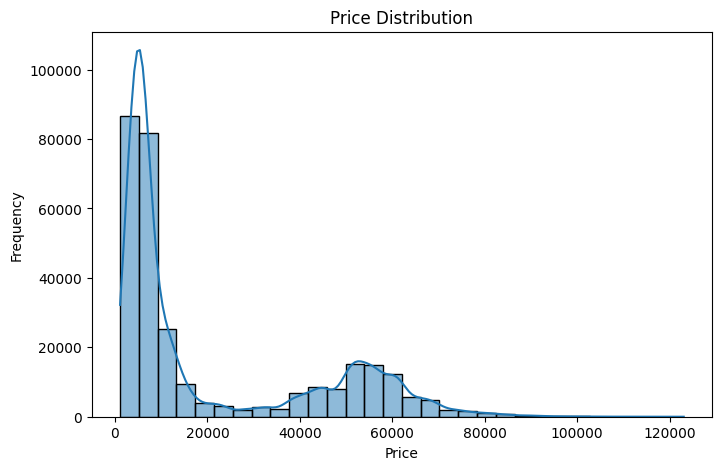

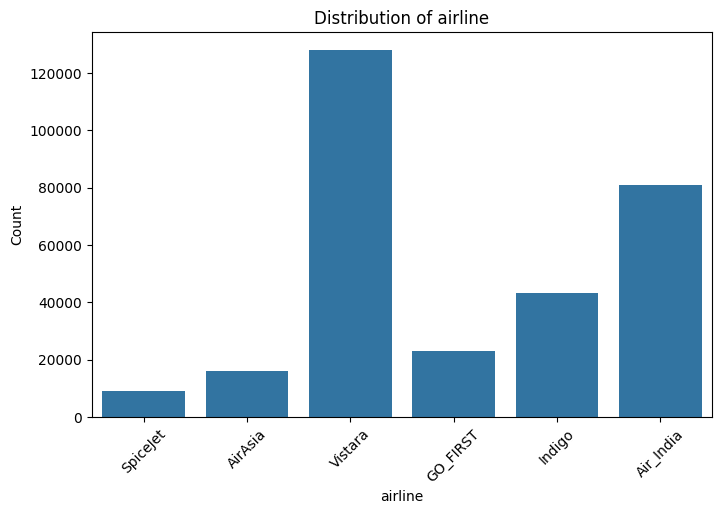

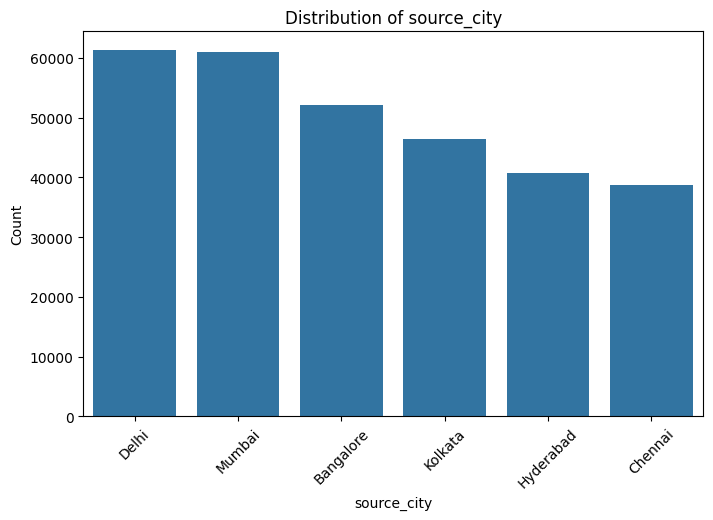

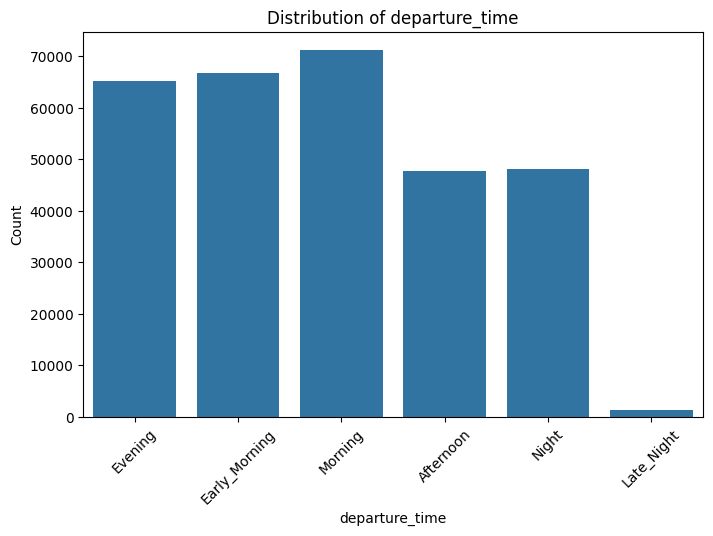

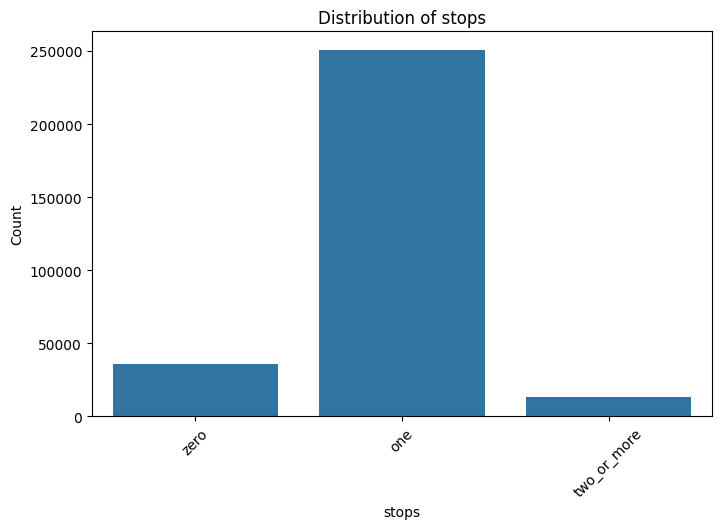

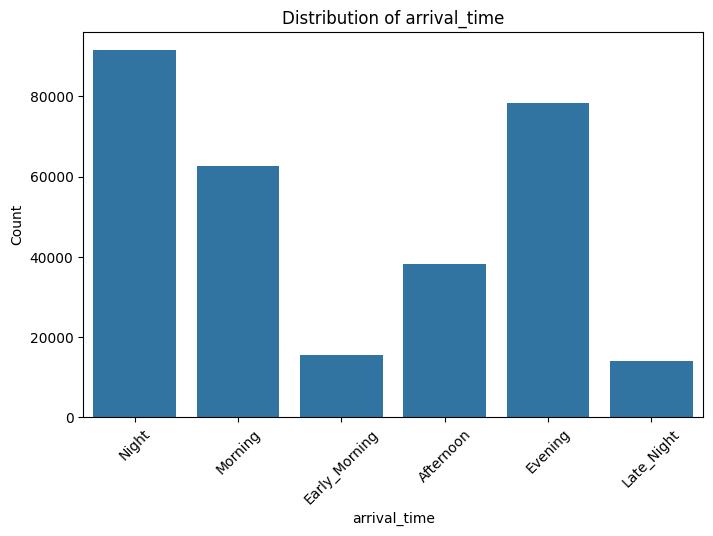

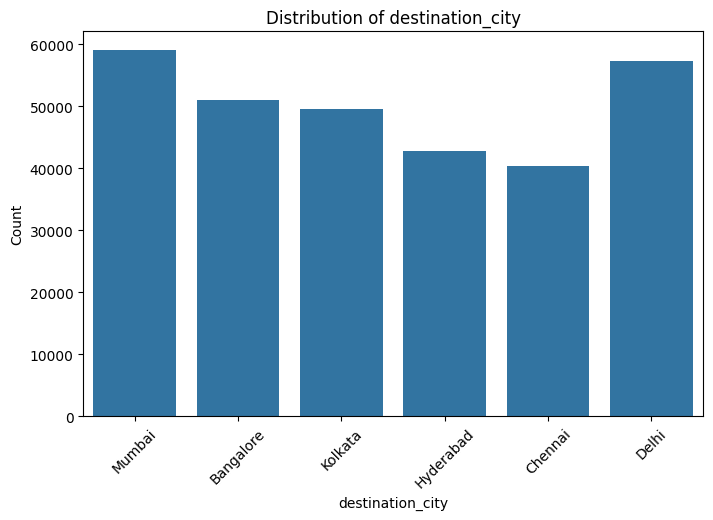

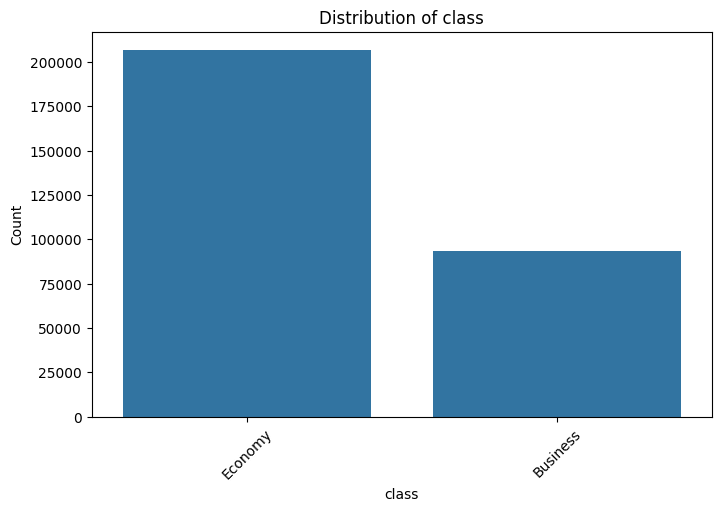

In [3]:
# Step 3: Data Exploration
# Analyze dataset shape, columns, and data types
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns}")
print(f"Data Types:\n{df.dtypes}")

# Check for missing values
print(f"Missing Values:\n{df.isnull().sum()}")

# Summary statistics of the dataset
df.describe()

# Visualize price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], kde=True, bins=30)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Categorical feature analysis
categorical_columns = [
    "airline",
    "source_city",
    "departure_time",
    "stops",
    "arrival_time",
    "destination_city",
    "class",
]
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [5]:
# Step 4: Data Cleaning and Preprocessing
# Remove any duplicates
df.drop_duplicates(inplace=True)

# Convert categorical features to numeric using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_data = encoder.fit_transform(df[categorical_columns])

# Combine encoded data with continuous features
categorical_columns_encoded = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(categorical_data, columns=categorical_columns_encoded)

continuous_columns = ["duration", "days_left"]
continuous_data = df[continuous_columns]

final_df = pd.concat([encoded_df, continuous_data, df["price"]], axis=1)

# Normalize continuous features using StandardScaler
scaler = StandardScaler()
final_df[continuous_columns] = scaler.fit_transform(final_df[continuous_columns])

# Display processed data
final_df.head()

,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,...,arrival_time_Night,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Economy,duration,days_left,price
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.397531,-1.843875,5953
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.375284,-1.843875,5953
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.397531,-1.843875,5956
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.386407,-1.843875,5955
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.375284,-1.843875,5955


In [6]:
# Step 5: Feature Engineering and Dimensionality Reduction
# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=10)  # Reducing to 10 principal components
pca_data = pca.fit_transform(final_df.drop(columns=["price"]))

# Combine PCA data with target variable
pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(10)])
pca_df["price"] = final_df["price"]

# Display explained variance ratio
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

Explained Variance Ratio: [0.19400688 0.1721068  0.06383376 0.05119216 0.04604775 0.04349366
 0.04146843 0.03886133 0.0384654  0.03396154]


In [7]:
# Step 6: Model Development
# Split data into training and testing sets
X = final_df.drop(columns=["price"])
y = final_df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {"MSE": mse, "MAE": mae, "R2": r2}
    print(f"{model_name} Performance:\nMSE: {mse}\nMAE: {mae}\nR2: {r2}\n")

# Hyperparameter tuning for Random Forest
param_grid = {"n_estimators": [100, 200], "max_depth": [10, 20, None]}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), param_grid, scoring="r2", cv=3
)
grid_search.fit(X_train, y_train)

print(f"Best Parameters for Random Forest: {grid_search.best_params_}")

Linear Regression Performance:
MSE: 45720769.75632413
MAE: 4553.28781678226
R2: 0.9113048651706634

Random Forest Performance:
MSE: 7869608.348679638
MAE: 1088.848228589369
R2: 0.9847335034545506

Gradient Boosting Performance:
MSE: 25011205.563431535
MAE: 2972.056919745378
R2: 0.9514799890396428

Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}


In [8]:
# Step 7: Deployment Considerations
# Propose a deployment strategy for the best-performing model
# Save the best model
import joblib

best_model = grid_search.best_estimator_
joblib.dump(best_model, "flight_price_model.pkl")

print("Model saved as 'flight_price_model.pkl' for deployment.")

Model saved as 'flight_price_model.pkl' for deployment.


Model Accuracy: 0.9847722687069231
Model Performance:
MSE: 7849625.54825111
MAE: 1087.116067355234
R2: 0.9847722687069231


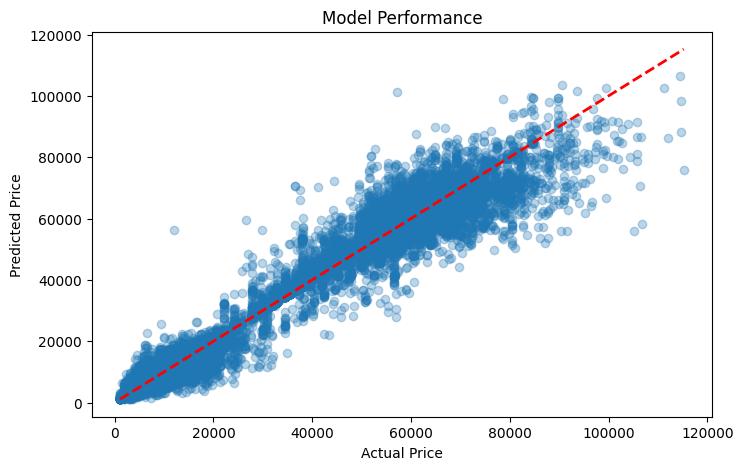

In [16]:
# Step 8: Model Evaluation
# Evaluate the best model
# Load the saved model
best_model = joblib.load("flight_price_model.pkl")

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Accuracy metrics
accuracy = best_model.score(X_test, y_test)

print(f"Model Accuracy: {accuracy}")
print(f"Model Performance:\nMSE: {mse}\nMAE: {mae}\nR2: {r2}")

# Visualize model performance
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Model Performance")
plt.show()